# Starbucks Capstone Challenge 

### Project Overview


This capstone project is using data provided by Udacity as part of the Data Scientist Nanodegree course. It contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Starbucks sends out an offer to users of the mobile app. Some users might not receive any offer during certain weeks, and not all users receive the same offer.

#### Business Questions

In my capstone project, I aim to answer following 2 business questions:

1. What proportions of the users complete the offers based on their age and gender
2. Which demographic responds best to the offers based on different offers to them.

#### Data

The data provided consists of 3 datasets:

1. Offer portfolio, which consists of the attributes of each offer (portfolio.json)
2. Demographic data for each customer (profile.json)
3. Transactional records of events occurring on the app (transcript.json)



### Data Sets

The data is contained in the following 3 files with their respective schemas

#### portfolio.json
This data set contains the user attributes. The schema of the dataset is as follows:
- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

#### profile.json
This data set contains the demographic area details, how different areas get different offers. It contains two of the most important features to answer our first business question, age and gender. We might explore the income affecting the offers as well. The schema for the dataset is as follows:
- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

#### transcript.json
This data set contains the transactional records for the various users and offers availed over the app. The schema is as follows:
- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

### Contents and Flow

## Imports and Loading Data

In [104]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
% matplotlib inline
from sklearn.metrics import fbeta_score, accuracy_score, f1_score
import datetime

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

After loading the data in the respective datasets, exploring the various features and how data is distributed across the various datasets

In [2]:
portfolio.shape, transcript.shape, profile.shape

((10, 6), (306534, 4), (17000, 5))

Exploring the portfolio dataset first

In [3]:
portfolio.head()

channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5

This contains the type of offers the user receives. Lets check for the different counts of the offers user receives over the app.

In [4]:
portfolio.describe()

difficulty   duration     reward
count   10.000000  10.000000  10.000000
mean     7.700000   6.500000   4.200000
std      5.831905   2.321398   3.583915
min      0.000000   3.000000   0.000000
25%      5.000000   5.000000   2.000000
50%      8.500000   7.000000   4.000000
75%     10.000000   7.000000   5.000000
max     20.000000  10.000000  10.000000

In [5]:
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

The user receives mostly BOGO (buy one get one) and discounted offers, followed by informational offers, which are in less quantity.

In [6]:
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

Since no null values exist in the dataset, no need to impute any values at all.

After portfolio, exploring the profile dataset

In [7]:
profile.head()

age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN

In [8]:
#Checking for any null values in the dataset
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Text(0.5,0,'Gender')

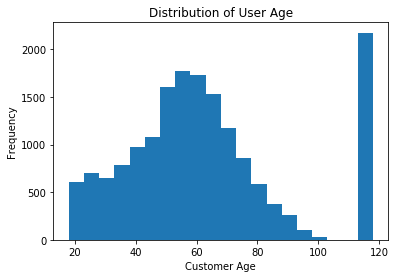

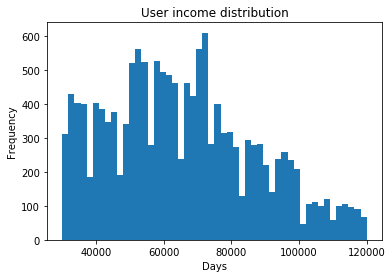

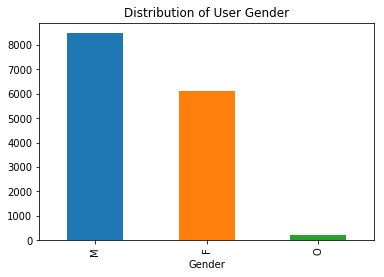

In [9]:
#checking age, income and gender distributions across the users
#Distribution of age
user_age = profile['age'].plot(kind='hist', bins=20, title='Distribution of User Age')
user_age.set_xlabel("Customer Age")
       
#Distribution of income
plt.figure()
user_income = profile['income'].plot(kind='hist', bins=50, title='User income distribution')
user_income.set_xlabel("Days")
    
# Display Histogram of User Income
plt.figure()
user_gender = profile['gender'].value_counts().plot.bar(title='Distribution of User Gender')
user_gender.set_xlabel("Gender")

Age=118 isn't making any sense, as it is clearly out of the normal distribution.

In [10]:
#checking count of age=118 value and corresponding gender and income columns
profile[profile['age']==118].count()


age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

These values corresponds to exactly the same number of values for which the gender and income have null values in the dataset

In [11]:
profile = profile.drop(profile[(profile["income"].isnull()) & (profile["age"] == 118)].index)

Text(0.5,0,'Customer Age')

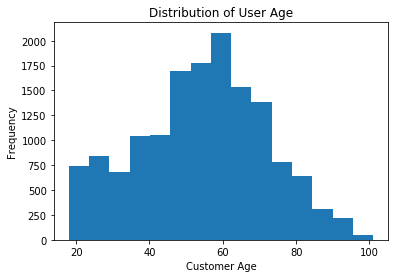

In [12]:
user_age = profile['age'].plot(kind='hist', bins=15, title='Distribution of User Age')
user_age.set_xlabel("Customer Age")

No more unexpected values of ages over 100 as that are clearly outliers (bad data) in our dataset.

In [13]:
#checking if there are still any null values in data set after deleting all the age=118 data values
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

####  Transactional Records

In [14]:
transcript.head()

event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}

In [15]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [16]:
#checking number of unique people represented, giving us the total user count
transcript['person'].nunique()

17000

In [17]:
#check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

There are no null values in this data.



In [18]:
#further info for the dataset
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### Data Cleaning 

Cleaning the 3 datasets for pre-processing and analyzing data to answer the business questions.

In [19]:
#firstly proceeding with portfolio dataset
def clean_portfolio(df=portfolio):
    """
    Takes the dataframe portfolio and cleans it by creating one-hot encodings.
    
    PARAMETERS:
        portfolio dataframe
        
    RETURNS:
        A new dataframe consisting of:
        ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    """
    
    # change the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    

    # https://stackoverflow.com/questions/18889588/create-dummies-from-column-with-multiple-values-in-pandas
    channels = cleaned_portfolio["channels"].str.join(sep="*").str.get_dummies(sep="*")
    
    #offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    
    new_df = pd.concat([df, channels, offer_type], axis=1, sort=False)
    
    # Remove channels and offer_type
    new_df = new_df.drop(['channels', 'offer_type'], axis=1)
    
    # Organize columns
    columns = ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    new_df = new_df[columns]
    
    
    return new_df

In [20]:
cleaned_portfolio = clean_portfolio() 
cleaned_portfolio.head(5)

id  difficulty  duration  reward  email  \
0  ae264e3637204a6fb9bb56bc8210ddfd          10         7      10      1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0          10         5      10      1   
2  3f207df678b143eea3cee63160fa8bed           0         4       0      1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           5         7       5      1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7          20        10       5      1   

   mobile  social  web  bogo  discount  informational  
0       1       1    0     1         0              0  
1       1       1    1     1         0              0  
2       1       0    1     0         0              1  
3       1       0    1     1         0              0  
4       0       0    1     0         1              0

Proceeding with profile dataset

In [21]:
profile.head(5)

age  became_member_on gender                                id    income
1    55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
3    75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
5    68          20180426      M  e2127556f4f64592b11af22de27a7932   70000.0
8    65          20180209      M  389bc3fa690240e798340f5a15918d5c   53000.0
12   58          20171111      M  2eeac8d8feae4a8cad5a6af0499a211d   51000.0

In [22]:
#cleaning the profile dataset
def clean_profile(profile = profile):
    """
    
    inpur:
        Profile dataframe.
        
    returns:
        A new dataframe whithout income values iqual to null and age iqual to 118 as well as one hot encoded columns.
    """
    #already deleted the age=118 entries
    
    # One-hot encode Gender column
    gender_dummies = pd.get_dummies(profile["gender"])
    
    # Specifying age range and one hot encoding
    range_ages = pd.cut(x=profile["age"], bins=[17,20, 29, 39, 49, 59, 69, 79, 89, 99])
    # One-hot encode ages column
    ages_dummies = pd.get_dummies(range_ages)
    
    # Specifying income range and one hot encoding
   
    range_income = pd.cut(x=profile["income"], bins=[30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000,  120000])
    income_dummies = pd.get_dummies(range_income)
    

    # Concat
    new_df = pd.concat([profile, ages_dummies, income_dummies, gender_dummies], axis=1, sort=False)
    
    # Dropping age,gender,income column
    new_df = new_df.drop(["age", "gender", "income"], axis=1)
    
    new_df

    
    return new_df

In [23]:
cleaned_profile = clean_profile() 
cleaned_profile.head(5)

became_member_on                                id  (17, 20]  (20, 29]  \
1           20170715  0610b486422d4921ae7d2bf64640c50b         0         0   
3           20170509  78afa995795e4d85b5d9ceeca43f5fef         0         0   
5           20180426  e2127556f4f64592b11af22de27a7932         0         0   
8           20180209  389bc3fa690240e798340f5a15918d5c         0         0   
12          20171111  2eeac8d8feae4a8cad5a6af0499a211d         0         0   

    (29, 39]  (39, 49]  (49, 59]  (59, 69]  (69, 79]  (79, 89] ...  \
1          0         0         1         0         0         0 ...   
3          0         0         0         0         1         0 ...   
5          0         0         0         1         0         0 ...   
8          0         0         0         1         0         0 ...   
12         0         0         1         0         0         0 ...   

    (50000, 60000]  (60000, 70000]  (70000, 80000]  (80000, 90000]  \
1                0               0               0               0   
3                0               0               0               0   
5                0               1               0               0   
8                1               0               0               0   
12               1               0               0               0   

    (90000, 100000]  (100000, 110000]  (110000, 120000]  F  M  O  
1                 0                 0                 1  1  0  0  
3                 1                 0                 0  1  0  0  
5                 0                 0                 0  0  1  0  
8                 0                 0                 0  0  1  0  
12                0                 0                 0  0  1  0  

[5 rows x 23 columns]

creating the plots for cleaned profile dataset for better understanding

Text(0.5,17.2,'Gender')

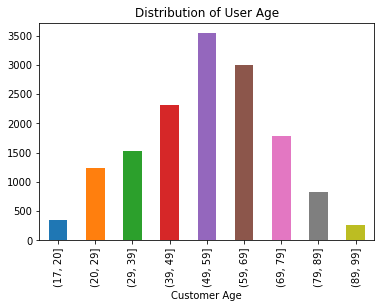

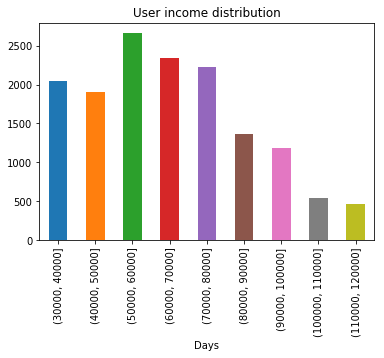

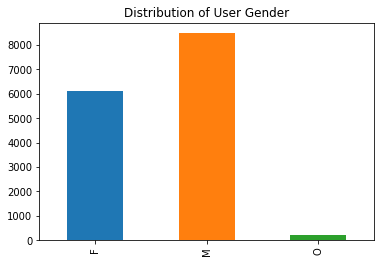

In [24]:
#checking age, income and gender distributions across the users on the cleaned profile dataset
user_age = cleaned_profile[cleaned_profile.columns[2:11]].sum().plot.bar( title='Distribution of User Age')
user_age.set_xlabel("Customer Age")
       
#Distribution of income
plt.figure()
user_income = cleaned_profile[cleaned_profile.columns[11:20]].sum().plot.bar(title='User income distribution')
user_income.set_xlabel("Days")
    
# Display Histogram of User Income
plt.figure()
user_gegder = cleaned_profile[cleaned_profile.columns[20:]].sum().plot.bar(title='Distribution of User Gender')
user_gender.set_xlabel("Gender")

Proceeding with cleaning the transcript Dataset

In [25]:
transcript.head(5)

event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}

In [26]:
# Functions to create offer id and amount columns from the transcript table.
def create_offer_id_column(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]

In [27]:
#function to clean the transcript
def clean_transcript(transcript = transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
        transcript - the transcript dataframe to be cleaned
    
    returns:
        offer - the cleaned offer dataframe
    '''
    #creating cleaned transcript dataset
    cleaned_transcript = transcript.copy()
    
    # extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
    cleaned_transcript['offer_id'] = transcript.value.apply(create_offer_id_column)
    
    #  One-hot encode event column
    event = pd.get_dummies(transcript['event'])
    
    # Concat one-hot and df
    cleaned_transcript = pd.concat([cleaned_transcript, event], axis=1, sort=False)
    
    # Create and Drop Transaction
    transaction = cleaned_transcript[cleaned_transcript["transaction"]==1]
    cleaned_transcript = cleaned_transcript.drop(transaction.index)
    
    #dropping value column as we no longer need it
    cleaned_transcript = cleaned_transcript.drop(columns=['value'])
    
    return cleaned_transcript

In [28]:
cleaned_transcript = clean_transcript()
cleaned_transcript.head(5)

event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                           offer_id  offer completed  offer received  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9                0               1   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7                0               1   
2  2906b810c7d4411798c6938adc9daaa5                0               1   
3  fafdcd668e3743c1bb461111dcafc2a4                0               1   
4  4d5c57ea9a6940dd891ad53e9dbe8da0                0               1   

   offer viewed  transaction  
0             0            0  
1             0            0  
2             0            0  
3             0            0  
4             0            0

In [29]:
cleaned_transcript.shape

(167581, 8)

In [30]:
cleaned_transcript[cleaned_transcript['offer completed']==1].shape

(33579, 8)

**We can see only about 20% of the offers have been completed by the users**

In [31]:
cleaned_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 8 columns):
event              167581 non-null object
person             167581 non-null object
time               167581 non-null int64
offer_id           167581 non-null object
offer completed    167581 non-null uint8
offer received     167581 non-null uint8
offer viewed       167581 non-null uint8
transaction        167581 non-null uint8
dtypes: int64(1), object(3), uint8(4)
memory usage: 7.0+ MB


## Analysis and Business Question Answering

In [32]:
cleaned_portfolio.head(5)

id  difficulty  duration  reward  email  \
0  ae264e3637204a6fb9bb56bc8210ddfd          10         7      10      1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0          10         5      10      1   
2  3f207df678b143eea3cee63160fa8bed           0         4       0      1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           5         7       5      1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7          20        10       5      1   

   mobile  social  web  bogo  discount  informational  
0       1       1    0     1         0              0  
1       1       1    1     1         0              0  
2       1       0    1     0         0              1  
3       1       0    1     1         0              0  
4       0       0    1     0         1              0

In [33]:
#renaming id column as offer id
cleaned_portfolio = cleaned_portfolio.rename(columns={'id':'offer_id'})

combining portfolio and transcript datasets, once that done, combining transcript and profile datasets. All the merges here will be taking place on the cleaned datasets, not on the original ones

But rather than merging individually its better to create a function for it, where all the merging takes place.

In [34]:

cleaned_transcript = cleaned_transcript.rename(columns={"person":"user_id"})
cleaned_transcript.head(5)

event                           user_id  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                           offer_id  offer completed  offer received  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9                0               1   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7                0               1   
2  2906b810c7d4411798c6938adc9daaa5                0               1   
3  fafdcd668e3743c1bb461111dcafc2a4                0               1   
4  4d5c57ea9a6940dd891ad53e9dbe8da0                0               1   

   offer viewed  transaction  
0             0            0  
1             0            0  
2             0            0  
3             0            0  
4             0            0

In [35]:
cleaned_portfolio.head(5)

offer_id  difficulty  duration  reward  email  \
0  ae264e3637204a6fb9bb56bc8210ddfd          10         7      10      1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0          10         5      10      1   
2  3f207df678b143eea3cee63160fa8bed           0         4       0      1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           5         7       5      1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7          20        10       5      1   

   mobile  social  web  bogo  discount  informational  
0       1       1    0     1         0              0  
1       1       1    1     1         0              0  
2       1       0    1     0         0              1  
3       1       0    1     1         0              0  
4       0       0    1     0         1              0

In [36]:
cleaned_profile.head(5)


became_member_on                                id  (17, 20]  (20, 29]  \
1           20170715  0610b486422d4921ae7d2bf64640c50b         0         0   
3           20170509  78afa995795e4d85b5d9ceeca43f5fef         0         0   
5           20180426  e2127556f4f64592b11af22de27a7932         0         0   
8           20180209  389bc3fa690240e798340f5a15918d5c         0         0   
12          20171111  2eeac8d8feae4a8cad5a6af0499a211d         0         0   

    (29, 39]  (39, 49]  (49, 59]  (59, 69]  (69, 79]  (79, 89] ...  \
1          0         0         1         0         0         0 ...   
3          0         0         0         0         1         0 ...   
5          0         0         0         1         0         0 ...   
8          0         0         0         1         0         0 ...   
12         0         0         1         0         0         0 ...   

    (50000, 60000]  (60000, 70000]  (70000, 80000]  (80000, 90000]  \
1                0               0               0               0   
3                0               0               0               0   
5                0               1               0               0   
8                1               0               0               0   
12               1               0               0               0   

    (90000, 100000]  (100000, 110000]  (110000, 120000]  F  M  O  
1                 0                 0                 1  1  0  0  
3                 1                 0                 0  1  0  0  
5                 0                 0                 0  0  1  0  
8                 0                 0                 0  0  1  0  
12                0                 0                 0  0  1  0  

[5 rows x 23 columns]

In [37]:
def concat_tables():
    
    # Rename column id with person to merge with transcript
    new_cleaned_profile = cleaned_profile.rename(columns={"id": "user_id" })
    
    
    #  Merge cleaned portfolio and transcript
    final_transcript = pd.merge(cleaned_transcript,cleaned_portfolio, on='offer_id')
    
    # Merge profile with transcript on person column
    final_transcript = pd.merge(final_transcript,new_cleaned_profile, on="user_id")
    
    return final_transcript

In [38]:
df = concat_tables()

In [39]:
df.head(5)

event                           user_id  time  \
0   offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1     offer viewed  78afa995795e4d85b5d9ceeca43f5fef     6   
2  offer completed  78afa995795e4d85b5d9ceeca43f5fef   132   
3   offer received  78afa995795e4d85b5d9ceeca43f5fef   504   
4  offer completed  78afa995795e4d85b5d9ceeca43f5fef   510   

                           offer_id  offer completed  offer received  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9                0               1   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9                0               0   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9                1               0   
3  f19421c1d4aa40978ebb69ca19b0e20d                0               1   
4  f19421c1d4aa40978ebb69ca19b0e20d                1               0   

   offer viewed  transaction  difficulty  duration ...  (50000, 60000]  \
0             0            0           5         7 ...               0   
1             1            0           5         7 ...               0   
2             0            0           5         7 ...               0   
3             0            0           5         5 ...               0   
4             0            0           5         5 ...               0   

   (60000, 70000]  (70000, 80000]  (80000, 90000]  (90000, 100000]  \
0               0               0               0                1   
1               0               0               0                1   
2               0               0               0                1   
3               0               0               0                1   
4               0               0               0                1   

   (100000, 110000]  (110000, 120000]  F  M  O  
0                 0                 0  1  0  0  
1                 0                 0  1  0  0  
2                 0                 0  1  0  0  
3                 0                 0  1  0  0  
4                 0                 0  1  0  0  

[5 rows x 40 columns]

**The above dataframe (df) is the final df that we need to answer the first business question**

In [40]:
df.shape

(148805, 40)

In [41]:
df.columns

Index([           'event',          'user_id',             'time',
               'offer_id',  'offer completed',   'offer received',
           'offer viewed',      'transaction',       'difficulty',
               'duration',           'reward',            'email',
                 'mobile',           'social',              'web',
                   'bogo',         'discount',    'informational',
       'became_member_on',           (17, 20],           (20, 29],
                 (29, 39],           (39, 49],           (49, 59],
                 (59, 69],           (69, 79],           (79, 89],
                 (89, 99],     (30000, 40000],     (40000, 50000],
           (50000, 60000],     (60000, 70000],     (70000, 80000],
           (80000, 90000],    (90000, 100000],   (100000, 110000],
         (110000, 120000],                'F',                'M',
                      'O'],
      dtype='object')

In [42]:
new_cols = ['event',          'user_id',             'time',
               'offer_id',  'offer completed',   'offer received',
           'offer viewed',      'transaction',       'difficulty',
               'duration',           'reward',            'email',
                 'mobile',           'social',              'web',
                   'bogo',         'discount',    'informational',
       'became_member_on',           '17 - 20',           '20 - 29',
                 '29 - 39',           '39 - 49',           '49 - 59',
                 '59 - 69',           '69 - 79',           '79 - 89',
                 '89 - 99',     '30k - 40k',     '40k - 50k',
           '50k - 60k',     '60k - 70k',     '70k - 80k',
           '80k - 90k',    '90k - 100k',   '100k - 110k',
         '110k - 120k',                'F',                'M',
                      'O']

In [43]:
new_cols

['event',
 'user_id',
 'time',
 'offer_id',
 'offer completed',
 'offer received',
 'offer viewed',
 'transaction',
 'difficulty',
 'duration',
 'reward',
 'email',
 'mobile',
 'social',
 'web',
 'bogo',
 'discount',
 'informational',
 'became_member_on',
 '17 - 20',
 '20 - 29',
 '29 - 39',
 '39 - 49',
 '49 - 59',
 '59 - 69',
 '69 - 79',
 '79 - 89',
 '89 - 99',
 '30k - 40k',
 '40k - 50k',
 '50k - 60k',
 '60k - 70k',
 '70k - 80k',
 '80k - 90k',
 '90k - 100k',
 '100k - 110k',
 '110k - 120k',
 'F',
 'M',
 'O']

In [44]:
df.columns = new_cols

In [45]:
df.head()

event                           user_id  time  \
0   offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1     offer viewed  78afa995795e4d85b5d9ceeca43f5fef     6   
2  offer completed  78afa995795e4d85b5d9ceeca43f5fef   132   
3   offer received  78afa995795e4d85b5d9ceeca43f5fef   504   
4  offer completed  78afa995795e4d85b5d9ceeca43f5fef   510   

                           offer_id  offer completed  offer received  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9                0               1   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9                0               0   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9                1               0   
3  f19421c1d4aa40978ebb69ca19b0e20d                0               1   
4  f19421c1d4aa40978ebb69ca19b0e20d                1               0   

   offer viewed  transaction  difficulty  duration ...  50k - 60k  60k - 70k  \
0             0            0           5         7 ...          0          0   
1             1            0           5         7 ...          0          0   
2             0            0           5         7 ...          0          0   
3             0            0           5         5 ...          0          0   
4             0            0           5         5 ...          0          0   

   70k - 80k  80k - 90k  90k - 100k  100k - 110k  110k - 120k  F  M  O  
0          0          0           1            0            0  1  0  0  
1          0          0           1            0            0  1  0  0  
2          0          0           1            0            0  1  0  0  
3          0          0           1            0            0  1  0  0  
4          0          0           1            0            0  1  0  0  

[5 rows x 40 columns]

In [46]:
# Number of completed taken
taken = df[df["offer completed"] == 1].shape[0]

# Number of records where offer not taken
not_taken = df[df["offer completed"] == 0].shape[0]

# offers completed to not completed
percent_taken = (taken / not_taken) * 100

# Print the results
print("Availed Offers: {}".format(taken))
print("Offers not availed: {}".format(not_taken))
print("Percentage of offers availed: {0:.2f}%".format(percent_taken))

Availed Offers: 32444
Offers not availed: 116361
Percentage of offers availed: 27.88%


## What Type of users avail Most offers

In [47]:
gender_based_taken = df[df['offer completed']==1][['F','M','O']].sum()
(gender_based_taken/taken)*100

F    47.703736
M    50.752065
O     1.544199
dtype: float64

Text(0.5,0,'Gender')

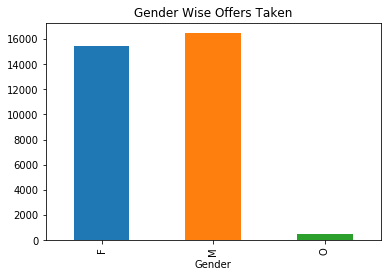

In [48]:
user_gender_dist = gender_based_taken.plot.bar(title='Gender Wise Offers Taken')
user_gender_dist.set_xlabel("Gender")



Text(0.5,0,'Income')

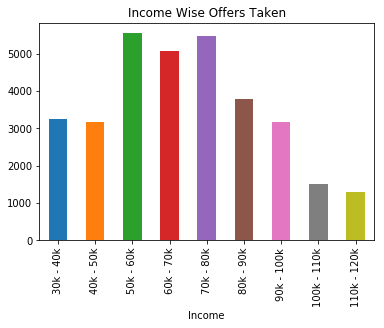

In [49]:
#defining age wise distribution for the offers taken
income_cols = ['30k - 40k','40k - 50k', '50k - 60k', '60k - 70k', '70k - 80k', '80k - 90k', '90k - 100k', '100k - 110k', '110k - 120k']
income_offer_taken = df[df['offer completed']==1][income_cols].sum()

#plot for income wise distribution for the offers taken
income_offer_taken_dist = income_offer_taken.plot.bar(title='Income Wise Offers Taken')
income_offer_taken_dist.set_xlabel("Income")



Text(0.5,0,'Age Groups')

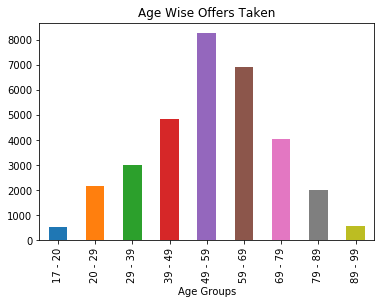

In [50]:
#age wise distribution for the offers availed
age_cols = ['17 - 20', '20 - 29', '29 - 39', '39 - 49', '49 - 59', '59 - 69', '69 - 79', '79 - 89', '89 - 99']
age_wise_offers_taken = df[df['offer completed']==1][age_cols].sum()
age_wise_offers_taken_dist = age_wise_offers_taken.plot.bar(title='Age Wise Offers Taken')
age_wise_offers_taken_dist.set_xlabel('Age Groups')

Text(0.5,0,'Offers Validity')

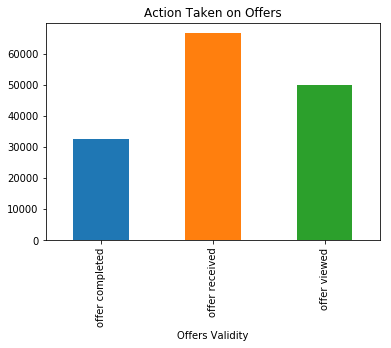

In [51]:
#offers wise distribution
offers_dist = df[['offer completed', 'offer received', 'offer viewed']].sum()
offers_dist_gr = offers_dist.plot.bar(title='Action Taken on Offers')
offers_dist_gr.set_xlabel('Offers Validity')

Text(0.5,0,'Offer Type')

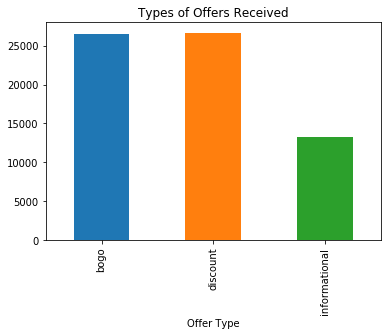

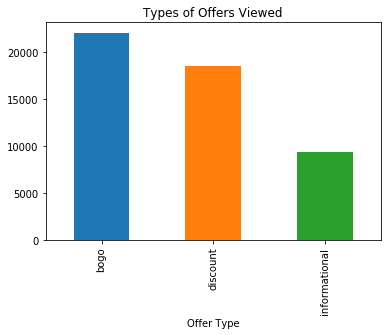

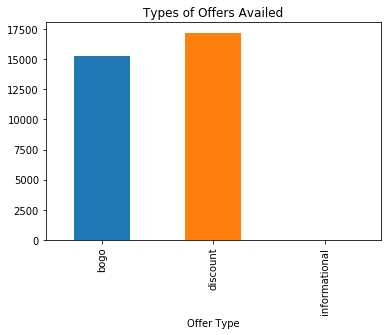

In [57]:
#types of offers viewed
offers_types = df[df['offer received']==1][['bogo', 'discount', 'informational']].sum()
offers_types_dist = offers_types.plot.bar(title='Types of Offers Received')
offers_types_dist.set_xlabel('Offer Type')

#types of offers viewed
plt.figure()
offers_types = df[df['offer viewed']==1][['bogo', 'discount', 'informational']].sum()
offers_types_dist = offers_types.plot.bar(title='Types of Offers Viewed')
offers_types_dist.set_xlabel('Offer Type')

#types of offers availed
plt.figure()
offers_type = df[df['offer completed']==1][['bogo', 'discount', 'informational']].sum()
offers_type_dist = offers_type.plot.bar(title='Types of Offers Availed')
offers_type_dist.set_xlabel('Offer Type')

In [58]:
(offers_type/df[df['offer completed']==1].shape[0])*100

bogo             47.028726
discount         52.971274
informational     0.000000
dtype: float64

In [66]:
#deeping further down on the offers availed, based on offers viewed and received
r = df[df['offer received']==1].shape[0]
v = df[df['offer viewed']==1].shape[0]
c = df[df['offer completed']==1].shape[0]

print('The percentage of offers viewed after receiving: {:.2f}'.format((v/r)*100))
print('The percentage of offers completed after receiving: {:.2f}'.format((c/r)*100))
print('The percentage of offers completed after viewing: {:.2f}'.format((c/v)*100))

The percentage of offers viewed after receiving: 74.98
The percentage of offers completed after receiving: 48.79
The percentage of offers completed after viewing: 65.07


In [93]:
#since only bogo and discount offers are taken, looking futher how many such offers were viewed and how many were completed
print("BOGO Offers First:")
b_r = df[df['offer received']==1]['bogo'].sum()
b_v = df[df['offer viewed']==1]['bogo'].sum()
b_c = df[df['offer completed']==1]['bogo'].sum()
                                   
print('The percentage of BOGO offers viewed after receiving: {:.2f}'.format((b_v/b_r)*100))
print('The percentage of BOGO offers completed after receiving: {:.2f}'.format((b_c/b_r)*100))
                                 

BOGO Offers First:
The percentage of BOGO offers viewed after receiving: 83.05
The percentage of BOGO offers completed after receiving: 57.50


In [94]:
#since only bogo and discount offers are taken, looking futher how many such offers were viewed and how many were completed
print("Discount Offers Now:")
d_r = df[df['offer received']==1]['discount'].sum()
d_v = df[df['offer viewed']==1]['discount'].sum()
d_c = df[df['offer completed']==1]['discount'].sum()
                                   
print('The percentage of discount offers viewed after receiving: {:.2f}'.format((d_v/d_r)*100))
print('The percentage of discount offers completed after receiving: {:.2f}'.format((d_c/d_r)*100))
                                  

Discount Offers Now:
The percentage of discount offers viewed after receiving: 69.24
The percentage of discount offers completed after receiving: 64.45


In [95]:
print("Discount Offers Now:")
i_r = df[df['offer received']==1]['informational'].sum()
i_v = df[df['offer viewed']==1]['informational'].sum()
i_c = df[df['offer completed']==1]['informational'].sum()

print('Total offers received for informational: {}'.format(i_r))
print('Total offers viewed for informational: {}'.format(i_v))
print('Total offers completed for informational: {}'.format(i_c))
print('The percentage of informational offers viewed after receiving: {:.2f}'.format((i_v/i_r)*100))



Discount Offers Now:
Total offers received for informational: 13300
Total offers viewed for informational: 9360
Total offers completed for informational: 0
The percentage of informational offers viewed after receiving: 70.38


### Effective Offers
After checking how BOGO and discount offers are availed, it is shown by the data more BOGO offers are viewed than discounted offers.

Also, users are more inclined to avail the discounted offers than bogo offers.
More discounted offers are availed (64%) than Bogo offers(57%), after viewing the offer.

## Conclusion For Business Questions


Lets try to explore the age wise distribution too, since we are already here

### Model Building and Implementation

In [96]:
df.head(5)

event                           user_id  time  \
0   offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1     offer viewed  78afa995795e4d85b5d9ceeca43f5fef     6   
2  offer completed  78afa995795e4d85b5d9ceeca43f5fef   132   
3   offer received  78afa995795e4d85b5d9ceeca43f5fef   504   
4  offer completed  78afa995795e4d85b5d9ceeca43f5fef   510   

                           offer_id  offer completed  offer received  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9                0               1   
1  9b98b8c7a33c4b65b9aebfe6a799e6d9                0               0   
2  9b98b8c7a33c4b65b9aebfe6a799e6d9                1               0   
3  f19421c1d4aa40978ebb69ca19b0e20d                0               1   
4  f19421c1d4aa40978ebb69ca19b0e20d                1               0   

   offer viewed  transaction  difficulty  duration ...  50k - 60k  60k - 70k  \
0             0            0           5         7 ...          0          0   
1             1            0           5         7 ...          0          0   
2             0            0           5         7 ...          0          0   
3             0            0           5         5 ...          0          0   
4             0            0           5         5 ...          0          0   

   70k - 80k  80k - 90k  90k - 100k  100k - 110k  110k - 120k  F  M  O  
0          0          0           1            0            0  1  0  0  
1          0          0           1            0            0  1  0  0  
2          0          0           1            0            0  1  0  0  
3          0          0           1            0            0  1  0  0  
4          0          0           1            0            0  1  0  0  

[5 rows x 40 columns]

In [97]:
df_final = df.drop(['event', 'user_id', 'time', 'offer_id', 'transaction', 'difficulty', 'duration', 'became_member_on'],axis=1)

In [98]:
df_final.head(5)

offer completed  offer received  offer viewed  reward  email  mobile  \
0                0               1             0       5      1       1   
1                0               0             1       5      1       1   
2                1               0             0       5      1       1   
3                0               1             0       5      1       1   
4                1               0             0       5      1       1   

   social  web  bogo  discount ...  50k - 60k  60k - 70k  70k - 80k  \
0       0    1     1         0 ...          0          0          0   
1       0    1     1         0 ...          0          0          0   
2       0    1     1         0 ...          0          0          0   
3       1    1     1         0 ...          0          0          0   
4       1    1     1         0 ...          0          0          0   

   80k - 90k  90k - 100k  100k - 110k  110k - 120k  F  M  O  
0          0           1            0            0  1  0  0  
1          0           1            0            0  1  0  0  
2          0           1            0            0  1  0  0  
3          0           1            0            0  1  0  0  
4          0           1            0            0  1  0  0  

[5 rows x 32 columns]

In [100]:
X = df_final.drop(['offer completed'], axis=1)
Y = df_final['offer completed']

In [101]:
X.shape, Y.shape

((148805, 31), (148805,))

In [110]:
#splitting the dataset in the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [111]:
#defining classifier, using random forest as the main classifier
classifier = RandomForestClassifier()

In [112]:
# training the data
classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [113]:
# making the predictions on the test
y_pred = classifier.predict(X_test)

In [115]:
#checking the accuracy and retrieving classification report of the predictions using classifier
print("Accuracy:",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     38465
          1       1.00      1.00      1.00     10641

avg / total       1.00      1.00      1.00     49106

